# Object Removal and Impainting Project
Participants:

- 
- 
- Alexei Ivanov (20917576)

# Abstract

The main goal of the project was to create a small notebook which would incorporate concepts from cs484 to complete the task of object removal and impaintaing. Our goal was to be able to remove images of planes flying through the sky on cameras and make it seems like the airspace was clear. We attempted to solve such a problem by using a sky dataset which included images of a clear sky and a conditional GAN as the generative impainting model. Through several interations and assumptions we were able to learn a model which somewhat completes the task. The generative model is quite good at reconstructing the non-cropped portion of the image but struggles to come up with a coherent filling for the cropped portion of the image. Through several attempts at the problem we learned that object removal and impainting is a much harder problem to solve than we initially thought. We left off with several improvements and consider for future improvements

# 1. Environment Setup (For reproducability)
Run the following cells to setup your environment

In [58]:
# install dependencies
!pip install -r requirements.txt

In [59]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from PIL import Image
from copy import deepcopy
import random
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import copy
import os

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 2. Dataset
Prior to settling on removing planes from the sky and impainting a sky background, our initial goal was to be able to do this for any background and not just a sky background. Our first iteration involved using ImageNet. The idea behind using such a large and diverse dataset was that our model could learn about various objects and thus would be able to reconstruct on a larger variety of backgrounds which usually could involve more expressive objects. Unfortunately when training the model on this dataset we found that the model was having difficulty learning the diverse dataset and started predicting the mean colour which resulted in a local minima. After taking this into consideration we switched to a smaller dataset while keeping the diversity relatively similar. We used OpenAI's Country211 dataset which had images from 211 countries. The goal in using this dataset was to still maintain diversity of training backgrounds but give far fewer examples in hopes of the model fitting better to simpler data. The model in this iteration was starting to predict greenish or blueish background but the test examples results were quite poor. We then decided not to encourage the model to learn about individual objects but to instead learn about backgrounds only and to try impaint through this type of learning. We switched to the Landscape High-Quality dataset which contained 90,000 images of landscapes which can be thought of as backgrounds. The model trained on this dataset exhibited similar behaviour to the prior iterations. We settled on using the a sky dataset found on Kaggle named swimseg-2. The dataset was filled with images of a clear sky with some clouds in the background. Since this dataset contained backgrounds from a single kind (sky) we thought that the model could better learn this single mode of data and get good at background impainting. There were far fewer examples in this dataset as well which allowed for longer training of the model.

## 2.1 Download Dataset
Visit [swimseg-2](https://www.kaggle.com/datasets/antigs/skyimage-dataset) and at the top right click the download button. Extract the zip folder into the current working directory and ensure that the directory is named "swimseg-2"

## 2.2 Sky Dataset Definition
The following is the definition of the sky dataset. It takes the root directory of the downloaded dataset and loads the data as follows:
1. Load image from the given directory
2. Apply given transforms to the image
3. Create a deep copy of the image. This copy is uncropped and will be used as the ground truth image while the other copy will be augmented to form the training image.
4. Crop the center 64x64 pixels of the 256x256 image and fill with random noise.

As a simplification to the object removal and impainting problem we assumed that the plane or sky object will always be in the center 64x64 square on the image. We remove this portion and fill it with random noise. We experimented with filling this with extreme values like 0 and 1, but filling it with random noise [0, 1) seemed to work best and was in the same fashion as the original GAN which sampled random noise vectors.

In [61]:
class SkyDataset(Dataset):
    def __init__(self, root_dir, transforms=None) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.transforms = transforms
        self.all_imgs = sorted(os.listdir(root_dir))
        

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        """
        This method is supposed to return training_img, correct_img. To generate this we do the following
        
            1) load the image
            2) apply given transforms to the image
            3) create a deep copy of the image which is going to be used as the ground truth image
            4) crop the center (CENTER_CROP_OUT_SIZE, CENTER_CROP_OUT_SIZE)
        """
        # (1) load image
        img_path = os.path.join(self.root_dir, self.all_imgs[index])
        image = Image.open(img_path).convert("RGB")

        # (2) apply given transforms to the image
        transformed_img = self.transforms(image) if self.transforms else image

        # (3) create deep copy of image
        ground_truth_image = deepcopy(transformed_img)

        # (4) crop the center
        #       an assumption here is that the image is 256x256 which is true because we constructed the transforms
        transformed_img[:, 96:160, 96:160] = torch.rand((3, 64, 64))

        return transformed_img, ground_truth_image

## 2.3 Transformations

We experimented with several transformations including different versions of crops and normalizations. The model performance was best when we simply converted pixel values to [0, 1] range and resized the entire image to 256x256 rather than taking a crop of the image.

In [62]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(size=(256, 256))
])

my_train_dataset = SkyDataset("swimseg-2/train", transforms=transforms)
my_val_dataset = SkyDataset("swimseg-2/val", transforms=transforms)
my_test_dataset = SkyDataset("swimseg-2/test", transforms=transforms)

/home/alex/miniconda3/envs/school/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## 2.4 Explore Dataset

In [63]:
item0, item1, item2 = my_test_dataset[0], my_test_dataset[1], my_test_dataset[2]

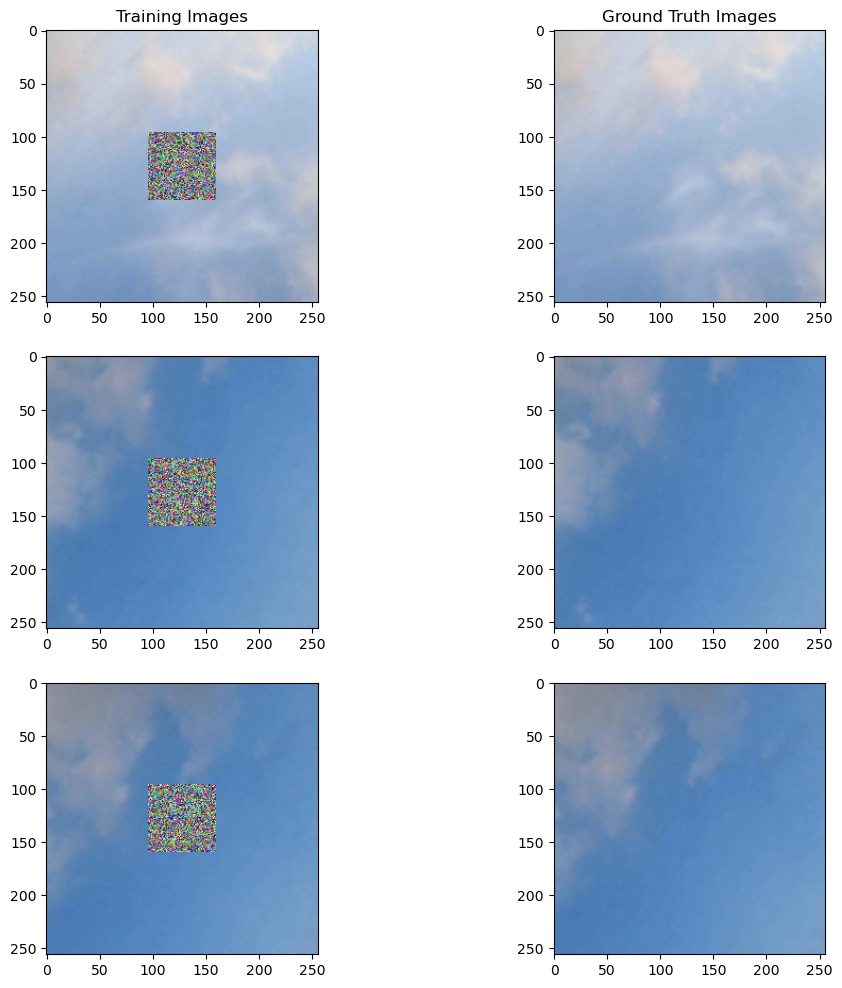

In [64]:
# train image 
f, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(np.transpose(item0[0], (1, 2, 0)))
ax[0, 1].imshow(np.transpose(item0[1], (1, 2, 0)))
ax[1, 0].imshow(np.transpose(item1[0], (1, 2, 0)))
ax[1, 1].imshow(np.transpose(item1[1], (1, 2, 0)))
ax[2, 0].imshow(np.transpose(item2[0], (1, 2, 0)))
ax[2, 1].imshow(np.transpose(item2[1], (1, 2, 0)))

ax[0, 0].set_title("Training Images");
ax[0, 1].set_title("Ground Truth Images");


## 2.5 Setup Dataloader

In [65]:
train_dataset, val_dataset, test_dataset = my_train_dataset, my_val_dataset, my_test_dataset

In [66]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 3. Model
The model we chose to go for was a conditional GAN. Instead of taking a vector of random noise the GAN generator will be conditioned on the cropped/masked image which includes random noise in the center and the outer non-cropped portion of the image. The model can thus condition on the non-cropped portion and have extra information used for generation. We chose this setup for a few reasons.

1. The model should be able to generate a coherent background even if it has never seen an outer crop of a particular style as well as fill in an area that has no data in it. GAN's are particularly good at generating new from a learned distribution. The goal was to learn the distribution of cloud and sky backgrounds and impaint the missing regions.
2. Although a regular generator in the GAN takes in a vector of random noise, we decided to condition our generator on the non-cropped portion of the images to allow the model to learn relationships between pixels around the cropped region as well. This would hopefully allow for a better impainting as all pixels would be taken into account during model generation and cloud patterns within the image could be preserved.

We also experimented with several different generator setups. Two of the notable ones have to do with the generation output. Our first idea was to generate the entire image (3x256x256) with the center portion of the image impainted. We ended up sticking to this type of generation as it yeilded the best results. We also tried only generating the center 3x64x64 portion and superimposing it onto the image. This type of generation didn't work as well and so we didn't end up using it.

## 3.1 Model Definitions
As we tried to get the best performance, one of the most basic ideas to performance is to scale up the model. During our experimentation we tried this and reported our results in the Experiments section. 

For model architecture we take took the standard encoder-decoder architecture using convolutions, transpose convolutions, pooling, and activation layers while building the models. Each model has outlined its dimensionality in the doc string.

### 3.1.1 Generators

In [67]:
class SmallGenerator(nn.Module):
    """
    This is the generator object of the GAN. The generator takes in the masked(cropped) image and fills in the masked/cropped out portion 
    by generating the entire image.

    The architecture takes inspiration from U-net:

    Encoder:
        1) 3x256x256 -> 64x128x128
        2) 64x128x128 -> 128x64x64
        3) 128x64x64 -> 256x32x32
        4) 256x32x32 -> 512x16x16

    Decoder:
        1) 512x16x16 -> 256x32x32
        2) (256 + 256)x32x32 -> 128x64x64 (skip connected from 3 in encoder)
        3) (128 + 128)x64x64 -> 64x128x128 (skip connected from 2 in encoder)
        4) (64 + 64)x128x128 -> 64x256x256 (skip connected from 1 in encoder)
        5) 64x256x256 -> 3x256x256
    """
    
    def __init__(self):
        super().__init__()

        # encoder layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # decoder layers
        self.convt1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.convt2 = nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2)
        self.convt3 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.convt4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.convt5 = nn.ConvTranspose2d(64, 3, kernel_size=1, stride=1)

        # non-learnable layers
        self.down_sample = nn.AvgPool2d(2)
        self.relu = torch.nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # encode
        x1 = self.bn1(self.relu(self.down_sample(self.conv1(x))))
        x2 = self.bn2(self.relu(self.down_sample(self.conv2(x1))))
        x3 = self.bn3(self.relu(self.down_sample(self.conv3(x2))))
        x4 = self.bn4(self.relu(self.down_sample(self.conv4(x3))))

        # decode
        x5 = self.convt1(x4)
        x6 = self.convt2(torch.concat([x5, x3], dim=1))
        x7 = self.convt3(torch.concat([x6, x2], dim=1))
        x8 = self.convt4(torch.concat([x7, x1], dim=1))
        x9 = self.convt5(x8)
        x10 = self.sigmoid(x9)

        return x10

In [68]:
model = SmallGenerator()

# Create a random input tensor with the specified shape (3x256x256)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass to get the output tensor
output_tensor = model(input_tensor)
output_tensor.shape

torch.Size([1, 3, 256, 256])

In [69]:
class LargeGenerator(nn.Module):
    """
    This is the generator object of the GAN. The generator takes in the masked(cropped) image and fills in the masked/cropped out portion.

    The architecture takes inspiration from U-net:

    Encoder:
        1) 3x256x256 -> 64x128x128
        2) 64x128x128 -> 128x128x128
        3) 128x128x128 -> 256x64x64
        4) 256x64x64 -> 512x64x64
        5) 512x64x64 -> 512x32x32
        6) 512x32x32 -> 512x32x32
        7) 512x32x32 -> 512x16x16
        8) 512x16x16 -> 512x16x16
        9) 512x16x16 -> 512x16x16
        10) 512x16x16 -> 512x16x16

    Decoder:
        1) 512x16x16 -> 512x16x16
        2) 512x16x16 -> 512x16x16
        3) 512x16x16 -> 512x16x16
        4) 512x16x16 -> 512x16x16
        5) 512x16x16 -> 512x16x16
        6) 512x16x16 -> 256x32x32
        7) 256x32x32 -> 128x64x64
        8) 128x64x64 -> 64x128x128
        9) 64x128x128 -> 64x256x256
        10) 64x256x256 -> 3x256x256
    """
    
    def __init__(self):
        super().__init__()

        # encoder layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(512)
        self.bn7 = nn.BatchNorm2d(512)
        self.bn8 = nn.BatchNorm2d(512)
        self.bn9 = nn.BatchNorm2d(512)
        self.bn10 = nn.BatchNorm2d(512)

        # decoder layers
        self.convt1 = nn.ConvTranspose2d(512, 512, kernel_size=1, stride=1)
        self.convt2 = nn.ConvTranspose2d(512, 512, kernel_size=1, stride=1)
        self.convt3 = nn.ConvTranspose2d(512, 512, kernel_size=1, stride=1)
        self.convt4 = nn.ConvTranspose2d(512, 512, kernel_size=1, stride=1)
        self.convt5 = nn.ConvTranspose2d(512, 512, kernel_size=1, stride=1)
        self.convt6 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.convt7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.convt8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.convt9 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.convt10 = nn.ConvTranspose2d(64, 3, kernel_size=1, stride=1)

        # non-learnable layers
        self.down_sample = nn.AvgPool2d(2)
        self.relu = torch.nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # encode
        x1 = self.bn1(self.relu(self.down_sample(self.conv1(x))))
        x2 = self.bn2(self.relu(self.conv2(x1)))
        x3 = self.bn3(self.relu(self.down_sample(self.conv3(x2))))
        x4 = self.bn4(self.relu(self.conv4(x3)))
        x5 = self.bn5(self.relu(self.down_sample(self.conv5(x4))))
        x6 = self.bn6(self.relu(self.conv6(x5)))
        x7 = self.bn7(self.relu(self.down_sample(self.conv7(x6))))
        x8 = self.bn8(self.relu(self.conv8(x7)))
        x9 = self.bn9(self.relu(self.conv9(x8)))
        x10 = self.bn10(self.relu(self.conv10(x9)))

        # decode
        x11 = self.convt1(x10)
        x12 = self.convt2(x11)
        x13 = self.convt3(x12)
        x14 = self.convt4(x13)
        x15 = self.convt5(x14)
        x16 = self.convt6(x15)
        x17 = self.convt7(x16)
        x18 = self.convt8(x17)
        x19 = self.convt9(x18)
        x20 = self.convt10(x19)
        x21 = self.sigmoid(x20)

        return x21


In [70]:
model = LargeGenerator()

# Create a random input tensor with the specified shape (3x256x256)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass to get the output tensor
output_tensor = model(input_tensor)
output_tensor.shape

torch.Size([1, 3, 256, 256])

### 3.1.2 Discriminators

In [71]:
class SmallDiscriminator(nn.Module):
    """
    This is the discriminator class. The discriminator takes in an image and its job is to classify whether the image is generated(fake) 
    or real (non-generated).

    The architecture of the network is the same as a simple CNN classifier

        1) 3x256x256 -> 64x128x128
        2) 64x128x128 -> 128x64x64
        3) 128x64x64 -> 256x32x32
        4) 256x32x32 -> 512x16x16
        5) 512x16x16 -> 512x1x1
        5) 512 -> 256
        6) 256 -> 10
        7) 10 -> 1
    """

    def __init__(self):
        super().__init__()

        # conv layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # batch norm layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # linear layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)
        self.fc3 = nn.Linear(10, 1)

        # non-learnable layers
        self.relu = nn.ReLU()
        self.down_sample = nn.AvgPool2d(2)
        self.max_pool = nn.MaxPool2d(16)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.bn1(self.relu(self.down_sample(self.conv1(x))))
        x = self.bn2(self.relu(self.down_sample(self.conv2(x))))
        x = self.bn3(self.relu(self.down_sample(self.conv3(x))))
        x = self.bn4(self.relu(self.down_sample(self.conv4(x))))

        x = self.max_pool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.fc1(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        # return un-normalized logit, can sigmoid after if you want
        return x

In [72]:
model = SmallDiscriminator()

# Create a random input tensor with the specified shape (3x256x256)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass to get the output tensor
output_tensor = model(input_tensor)
output_tensor.shape

torch.Size([1, 1])

In [73]:
class LargeDiscriminator(nn.Module):
    """
    This is the discriminator class. The discriminator takes in an image and its job is to classify whether the image is generated(fake) 
    or real (non-generated).

    The architecture of the network is the same as a simple CNN classifier

        1) 3x256x256 -> 64x128x128
        2) 64x128x128 -> 128x64x64
        3) 128x64x64 -> 256x32x32
        4) 256x32x32 -> 512x16x16
        5) 512x16x16 -> 512x1x1
        6) 512 -> 512
        7) 512 -> 512
        8) 512 -> 256
        9) 256 -> 10
        10) 10 -> 1
    """

    def __init__(self):
        super().__init__()

        # conv layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # batch norm layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # linear layers
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.fc5 = nn.Linear(10, 1)

        # non-learnable layers
        self.relu = nn.ReLU()
        self.down_sample = nn.AvgPool2d(2)
        self.max_pool = nn.MaxPool2d(16)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.bn1(self.relu(self.down_sample(self.conv1(x))))
        x = self.bn2(self.relu(self.down_sample(self.conv2(x))))
        x = self.bn3(self.relu(self.down_sample(self.conv3(x))))
        x = self.bn4(self.relu(self.down_sample(self.conv4(x))))

        x = self.max_pool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))

        return x

In [74]:
model = LargeDiscriminator()

# Create a random input tensor with the specified shape (3x256x256)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass to get the output tensor
output_tensor = model(input_tensor)
output_tensor.shape

torch.Size([1, 1])

### 3.1.3 Weight Initialization

In the original [DCGAN paper](https://arxiv.org/abs/1511.06434) the authors specify that the weights are best initialized from a Normal distribution $\mathcal{N}(0, 0.02)$

In [75]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 4. Losses, Optimizers and Schedulers

## 4.1 Losses

In a regular Deep Convolution Generative Adversarial Network (DCGAN) the loss can be represented as 
$$\min_{G}\max_{D}V(D, G) = \mathbb{E}_{x \sim p_{data}(x)} [\log D_{\theta_D}(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D_{\theta_D}(G_{\theta_G}(z)))]$$
where $D_{\theta_D}(\cdot)$ is the discriminator parametrized by $\theta_D$, $G_{\theta_G}(\cdot)$ is the generator parametrized by $\theta_G$, and $z$ is a latent space vector sampled from the normal distribution (noise).

In our formulation we take further this concept by adding a L2 regularization term on the models parameters to combat overfitting and ensure that the model learns good representations. We also take the loss a step further by adding a "photo-consistency" term which we call the reconstruction loss. The point of the reconstruction loss is to ensure there is consistency between the ground truth image and the reconstructed image. Lastly we weight each component of the loss by hyperparameters $\alpha, \beta$ which allow the users to control whether the model is focused more on reconstruction or fooling the discriminator (generating more "real" looking data). The combined loss is of the following form:

$$\min_{G}\max_{D}V(D, G) = \alpha(\mathbb{E}_{x\sim p_{data}(x)} [\log D_{\theta_D}(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D_{\theta_D}(G_{\theta_G}(z)))] + \delta_G \sum_{i} \theta_{G, i}) + \delta_D \sum_{i} \theta_{D, i} + \beta(\mathbb{E}_{x, y \sim p_{data}(x)}\ell_{rec}(x, y))$$

We tried several configurations and documented it in the experimentation section. The following is a list of all the losses we tried
1. L1 Loss: $\ell_{rec}(x, y) = \sum_{i}|x_i - y_i|$
2. L2 Loss: $\ell_{rec}(x, y) = \sum_{i}(x_i - y_i)^2$
3. Weighted L1 Loss: $\ell_{rec}(x, y) = \sum_{i}w_i|x_i - y_i|$
4. Weighted L2 Loss: $\ell_{rec}(x, y) = \sum_{i}w_i(x_i - y_i)^2$
5. Huber Loss: $\ell_{rec}(x, y) = \sum_{i} l_i$ where 

$$l_i =  \begin{cases} 
      0.5(x_i - y_i)^2 & |x_i - y_i| < \delta \\
      \delta \times (|x_i - y_i| - 0.5\times \delta) & else
       \\
   \end{cases}
$$

L1 favours sparsity while L2 loss punishes larger values harder the L1 loss but doesn't favour sparsity. This can lead to generating patchy images if using L2 loss, but we experimented with both. We decided to try out their weighted versions as well as this would allow us to place heavier weights on the cropped portion of the image. This would make the model penalties higher for getting a wrong reconstruction inside the cropped region. This type of weighting would hopefully force the model to really learn how to reconstruct the cropped portion of the images much better than the non-cropped portions. Lastly, Huber loss combines both L1 and L2 loss. It uses L1 loss if the difference between pixels if large than $\delta$ and otherwise uses L2 Loss.

In [76]:
class weighted_L2Loss(nn.Module):
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction
    def forward(self,inputs,targets,weights=None):
        weights = weights if weights is not None else torch.tensor([1], device=device)
        non_reduced = (((inputs - targets) ** 2) * weights)
        return non_reduced.sum() if self.reduction == 'sum' else non_reduced.mean()

In [77]:
class weighted_L1Loss(nn.Module):
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction
    def forward(self,inputs,targets,weights=None):
        weights = weights if weights is not None else torch.tensor([1], device=device)
        non_reduced = ((torch.abs(inputs - targets)) * weights)
        return non_reduced.sum() if self.reduction == 'sum' else non_reduced.mean()

In [78]:
generator_loss = nn.BCELoss()
discriminator_loss = nn.BCELoss()

In [79]:
generator_reconstruction_loss_l1 = nn.L1Loss(reduction="sum")
generator_reconstruction_loss_l1_weighted = weighted_L1Loss(reduction="sum")
generator_reconstruction_loss_l2 = nn.MSELoss(reduction="sum")
generator_reconstruction_loss_l2_weighted = weighted_L2Loss(reduction="sum")
generator_reconstruction_loss_huber = nn.HuberLoss(reduction="sum", delta=0.05)

## 4.2 Optimizers

We used the Adam optimizer with and set the learning rates based on what was best observed for the model training. In all cases we used $\delta_G = \delta_D = 0.9$ for L2 loss regularization

In [80]:
def get_optimizer(model, lr):
    return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.9)

## 4.3 Schedulers

Since we trained for several epochs, we want the model to be able to learn and eventually converge to a good results. In order to ensure exploration in the begginning stages of training we can keep a regular learning rate but slightly decrease it over each epoch to ensure that the model will learn less towards the end of training. This is usually done to ensure that the model learns well in the beggining and is able to overcome any local minima while in later stages the model makes smaller changes the its parameters as we hypothesize it approaches the global maximum (this is very optimistic).

For our experiments we used an Exponential scheduler which decays the learning rate by gamma each epoch. We set gamma to 0.9 for our experiments.

In [81]:
def get_scheduler(optimizer):
    return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

## 4.4 Training

The number of epoch we trained for was a hyper parameter, but given the resource constraints we tried to keep epoch to a minimum. Throughout the experiments we kept the model that performed best on the validation data, we considered this model the "trained" model.

The training scheme was closely followed from Goodfellows [paper](https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf) on GAN's.

In [94]:
def train(generator, discriminator, num_epochs, gen_lr, disc_lr, a, b, generator_reconstruction_loss):
    # init logger for tensorboard
    writer = SummaryWriter()

    # use gpu
    generator = generator.to(device)
    discriminator = discriminator.to(device)


    # keep best model
    iteration = 0
    best_generator, best_discriminator = generator, discriminator
    best_val_metric = float("inf")

    # get optimizers
    generator_optimizer = get_optimizer(generator, lr=gen_lr)
    discriminator_optimizer = get_optimizer(discriminator, lr=disc_lr)

    # get schedulers
    generator_scheduler = get_scheduler(generator_optimizer)
    discriminator_scheduler = get_scheduler(discriminator_optimizer)

    print("Beginning training")
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}")
        for i, data in enumerate(train_loader):
            
            x, y = data
            x, y = x.to(device), y.to(device)
            batch_size = x.size(0)
            
            # ------------------------------------------------------#
            # train Discriminator first
            discriminator.zero_grad()

            # all real batch
            true_labels = torch.ones(batch_size, device=device)
            
            # forward
            output = discriminator(y).view(-1)
            
            # loss
            err_real = discriminator_loss(output, true_labels)

            # backward
            err_real.backward()

            # all fake batch
            fake_label = torch.zeros(batch_size, device=device)

            # forward
            fake_generated = generator(x)
            output = discriminator(fake_generated.detach()).view(-1)

            # loss
            err_fake = discriminator_loss(output, fake_label)

            # log loss to tensorboard
            writer.add_scalar("Loss/train/discriminator", (err_fake + err_real) / 2, iteration)

            # backward
            err_fake.backward()

            # update discriminator
            discriminator_optimizer.step()
            # ---------------------------------------------------------#

            # ---------------------------------------------------------#
            # train generator
            generator.zero_grad()

            # labels now should be real so that we confuse discriminator that
            # generator is creating real images
            real_label = torch.ones(batch_size, device=device)
            output = discriminator(fake_generated).view(-1)

            # loss
            if isinstance(generator_reconstruction_loss, (weighted_L1Loss, weighted_L2Loss)):
                weights = torch.ones_like(y)
                weights[:, :, 96:160, 96:160] = 3
                err_generator = a*generator_loss(output, real_label) + b*generator_reconstruction_loss(fake_generated, y, weights=weights)
            else:
                err_generator = a*generator_loss(output, real_label) + b*generator_reconstruction_loss(fake_generated, y)

            # log loss to tensorboard
            writer.add_scalar("Loss/train/generator", err_generator, iteration)

            # backward
            err_generator.backward()

            # update generator
            generator_optimizer.step()
            # ---------------------------------------------------------#

            iteration += 1
        
        # step schedulers
        generator_scheduler.step()
        discriminator_scheduler.step()

        
        # evaluate on validation set
        with torch.no_grad():
            generator.eval()
            discriminator.eval()
            print(f"Epoch {epoch} finished calculating validation metrics")
            val_loss = 0
            for i, data in enumerate(val_loader):
                x, y = data
                x, y = x.to(device), y.to(device)
                batch_size = x.size(0)

                output = generator(x)
                fake_label = torch.zeros(batch_size, device=device)
                val_loss += a*generator_loss(discriminator(output).view(-1), fake_label) + b*generator_reconstruction_loss(output, y) 
            
            writer.add_scalar("Loss/val", val_loss, epoch)
            if val_loss <= best_val_metric:
                best_generator, best_discriminator = copy.deepcopy(generator), copy.deepcopy(discriminator)
        
        generator.train()
        discriminator.train()
        

    writer.flush()
    writer.close()
    return best_generator, best_discriminator


# 5. Experiments

We experimented with a number of setups but they can be loosely classified as the following

1. Loss Function
2. Reconstruction vs Fooling Discriminator
3. Model Size

In order to evaluate the model on the test training set we will use the following function

In [103]:
def eval_on_test(trained_generator, trained_discriminator):
    l = torch.nn.L1Loss()
    with torch.no_grad():
        trained_generator.eval()
        trained_discriminator.eval()

        N = 0
        loss = 0
        for i, data in enumerate(test_loader):
            x, y = data
            x, y = x.to(device), y.to(device)

            output = trained_generator(x)
            loss += l(output, y)
        
            N += x.size(0)
        
    return loss / N

## 5.1 Loss Function
We trained models using the different loss functions described in section 4.1. We fixed the number of epochs to 20 as based on the training plots this is where most of the training gains seemed to stop. We weight both the reconstruction loss and the regular loss as equal $\alpha = \beta = 0.5$. For now we used the smaller models to get a grasp of which loss function performs better. To programatically do this over the test dataset we needed to decide on a single loss function that was going to be used to judge which training loss function performs best. We decided that the simplest loss to use is L1 Loss. All the comparisons are done in terms of L1 Loss for the test set.

In [83]:
epochs = 20
alpha, beta = 0.5, 0.5
generator_lr = 1e-3
discriminator_lr = 1e-4

### 5.1.1 L1 Loss

In [85]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
ell = generator_reconstruction_loss_l1

l1_trained_generator, l1_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

![5.1.1](images/5.1.1.png)

### 5.1.2 L2 Loss

In [95]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
ell = generator_reconstruction_loss_l2

l2_trained_generator, l2_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

![5.1.2](images/5.1.2.png)

### 5.1.3 Weighted L1 Loss
For the weights we use a weight of 1 on pixels that are part of the non-cropped center region. We place a higher weight on the center cropped region to promote the model to better learn the reconstruction from noise. We tripple the penalty on center pixels. That is 
$$w_i =  \begin{cases} 
      1 & \text{if not in center cropped region} \\
      3 & \text{if in center cropped region}
       \\
   \end{cases}
$$

In [96]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
ell = generator_reconstruction_loss_l1_weighted

l1_weighted_trained_generator, l1_weighted_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0


/home/alex/miniconda3/envs/school/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metrics
Epoch: 17
Epoch 17 finishe

![5.1.3](images/5.1.3.png)

### 5.1.4 Weighted L2 Loss
We use the same weighting scheme here as in 5.1.3

In [98]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
ell = generator_reconstruction_loss_l2_weighted

l2_weighted_trained_generator, l2_weighted_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

![5.1.4](images/5.1.4.png)

### 5.1.5 Huber Loss

In [99]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
ell = generator_reconstruction_loss_huber

huber_weighted_trained_generator, huber_weighted_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

![5.1.5](images/5.1.5.png)

### 5.1.6 Results Comparison

In [107]:
losses = [eval_on_test(l1_trained_generator, l1_trained_discriminator).detach().cpu(),
          eval_on_test(l2_trained_generator, l2_trained_discriminator).detach().cpu(),
          eval_on_test(l1_weighted_trained_generator, l1_weighted_trained_discriminator).detach().cpu(),
          eval_on_test(l2_weighted_trained_generator, l2_weighted_trained_discriminator).detach().cpu(),
          eval_on_test(l1_trained_generator, l1_trained_discriminator).detach().cpu()]
model_names = ["L1 Loss", "L2 Loss", "Weighted L1 Loss", "Weighted L2 Loss", "Huber Loss"]

for i in range(len(model_names)):
    print(f"Test Set Loss ({model_names[i]}): {losses[i]}")

best = np.argmin(losses)
print()
print(f"Best Model is trained with: {model_names[best]}")

/home/alex/miniconda3/envs/school/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Set Loss (L1 Loss): 0.005832212045788765
Test Set Loss (L2 Loss): 0.003459003521129489
Test Set Loss (Weighted L1 Loss): 0.003358167828992009
Test Set Loss (Weighted L2 Loss): 0.0025506052188575268
Test Set Loss (Huber Loss): 0.005659498739987612

Best Model is trained with: Weighted L2 Loss


## 5.2

We experiment on the tradeoff between fooling the discriminator and the reconstruction loss. We will use the best performing loss function from the previous experiments. 

In [108]:
epochs = 20
generator_lr = 1e-3
discriminator_lr = 1e-4
ell = generator_reconstruction_loss_l2_weighted

### 5.2.1 
This experiment involves only using the discriminator and no reconstruction loss. That is $\alpha = 1, \beta = 0$

In [110]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
alpha=1
beta=0

alpha_1_beta_0_trained_generator, alpha_1_beta_0_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

### 5.2.2
This experiment involves using larger part of discriminator loss but also including some reconstruction loss. That is $\alpha=0.75, \beta=0.25$

In [111]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
alpha=0.75
beta=0.25

alpha_75_beta_25_trained_generator, alpha_75_beta_25_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

### 5.2.3
This experiment involves using equal parts of discriminator and reconstruction loss. That is $\alpha = 0.5, \beta = 0.5$

In [112]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
alpha=0.5
beta=0.5

alpha_5_beta_5_trained_generator, alpha_5_beta_5_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

### 5.2.4
This experiment involves using more of the reconstruction loss than the discriminator loss. That is $\alpha = 0.25, \beta=0.75$

In [113]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
alpha=0.25
beta=0.75

alpha_25_beta_75_trained_generator, alpha_25_beta_75_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

### 5.2.5
This experiment involves using only reconstruction loss. That is $\alpha = 0, \beta=1$

In [114]:
generator = SmallGenerator()
discriminator = SmallDiscriminator()
alpha=0
beta=1

alpha_0_beta_1_trained_generator, alpha_0_beta_1_trained_discriminator = train(generator=generator,
                                                 discriminator=discriminator,
                                                 num_epochs=epochs,
                                                 gen_lr=generator_lr,
                                                 disc_lr=discriminator_lr,
                                                 a=alpha, 
                                                 b=beta,
                                                 generator_reconstruction_loss=ell)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics
Epoch: 2
Epoch 2 finished calculating validation metrics
Epoch: 3
Epoch 3 finished calculating validation metrics
Epoch: 4
Epoch 4 finished calculating validation metrics
Epoch: 5
Epoch 5 finished calculating validation metrics
Epoch: 6
Epoch 6 finished calculating validation metrics
Epoch: 7
Epoch 7 finished calculating validation metrics
Epoch: 8
Epoch 8 finished calculating validation metrics
Epoch: 9
Epoch 9 finished calculating validation metrics
Epoch: 10
Epoch 10 finished calculating validation metrics
Epoch: 11
Epoch 11 finished calculating validation metrics
Epoch: 12
Epoch 12 finished calculating validation metrics
Epoch: 13
Epoch 13 finished calculating validation metrics
Epoch: 14
Epoch 14 finished calculating validation metrics
Epoch: 15
Epoch 15 finished calculating validation metrics
Epoch: 16
Epoch 16 finished calculating validation metric

### 5.2.6 Evaluate Results

## 5.3 Model Size
A simple way to get better results is to usually increase the complexity of your model. This usually allows the model to learn more complex behaviour and in the recent times has shown to be an easy with get more human like results (at least for NLP applications). Although the increase in complexity between our small model and large model is no where near the increase to get truly human like reconstructions, we attempted this experiment to get some gains on the loss. 

We take the approach that has yeilded the best results so far and simple apply a larger discriminator and generator.

# Explore Trained Model

In [ ]:
generator.eval()
discriminator.eval()
trained_generator.eval()
trained_discriminator.eval()

In [ ]:
item = my_train_dataset[5]
print(item[0].shape, item[1].shape)

In [ ]:
cropped_img = item[0][None].to(device)
inp = torch.randn(1, 3, 256, 256, device=device)
with torch.no_grad():
    output = trained_generator(cropped_img).detach().cpu()

plt.figure()
reconstructed = cropped_img[0]
# reconstructed[:, 96:160, 96:160] = output[0].detach().cpu()
plt.imshow(np.transpose(output[0].detach().cpu().numpy(), (1, 2, 0)))

In [ ]:
plt.figure()
plt.imshow(np.transpose(item[1].detach().cpu().numpy(), (1, 2, 0)))

# Save Model

In [ ]:
# torch.save(trained_generator.state_dict(), "models/generator/generator.pt")

In [ ]:
# torch.save(trained_discriminator.state_dict(), "models/discriminator/discriminator.pt")